In [1]:
from util import plot_data, get_mnist, print_predict_image
import tensorflow as tf
import keras
from time import time

tf.reset_default_graph()

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
x_train, y_train, y_train_classes, x_test, y_test = get_mnist()

Train labels: 60000
Test labels: 10000


In [3]:
def build_cnn(features, labels, mode):
    input_layer = features['X']

    with tf.name_scope("conv1"):
        conv1 = tf.layers.conv2d(inputs=input_layer, filters=32, kernel_size=[5, 5], activation=tf.nn.relu,
                                 padding='same')

    with tf.name_scope("pool1"):
        pooling1 = tf.layers.max_pooling2d(
            inputs=conv1, pool_size=[2, 2], strides=2)

    with tf.name_scope("conv2"):
        conv2 = tf.layers.conv2d(inputs=pooling1, filters=64, kernel_size=[5, 5], activation=tf.nn.relu,
                                 padding='same')

    with tf.name_scope("pool2"):
        pooling2 = tf.layers.max_pooling2d(
            inputs=conv2, pool_size=[2, 2], strides=2)

    with tf.name_scope("flatten"):
        flattening = tf.reshape(pooling2, [-1, 7 * 7 * 64])

    with tf.name_scope("dense"):
        dense = tf.layers.dense(
            inputs=flattening, units=1024, activation=tf.nn.relu)

    with tf.name_scope("dropout"):
        dropout = tf.layers.dropout(
            inputs=dense, rate=0.2, training=mode == tf.estimator.ModeKeys.TRAIN)

    with tf.name_scope("output"):
        output_layer = tf.layers.dense(inputs=dropout, units=10)

        predicts = tf.argmax(output_layer, axis=1)

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predicts)

    error = tf.losses.softmax_cross_entropy(
        onehot_labels=labels, logits=output_layer)

    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        train = optimizer.minimize(
            error, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=error, train_op=train)

    if mode == tf.estimator.ModeKeys.EVAL:
        eval_metric_ops = {
            'acc': tf.metrics.accuracy(
                tf.argmax(input=output_layer, axis=1),
                tf.argmax(input=labels, axis=1))
        }

        return tf.estimator.EstimatorSpec(mode=mode, predictions=predicts,
                                          loss=error, eval_metric_ops=eval_metric_ops)

In [4]:
classifier = tf.estimator.Estimator(
    model_fn=build_cnn, model_dir='./mnist_tf_estimator')

input_fn = tf.estimator.inputs.numpy_input_fn(x={'X': x_train}, y=y_train, batch_size=128,
                                              num_epochs=None, shuffle=True)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './mnist_tf_estimator', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f8969b41908>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [5]:
classifier.train(input_fn=input_fn, steps=200)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Use keras.layers.max_pooling2d instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Saving checkpoin

In [6]:
test_fn = tf.estimator.inputs.numpy_input_fn(x={'X': x_test}, y=y_test, num_epochs=1,
                                             shuffle=False)
results = classifier.evaluate(input_fn=test_fn)
print(results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-05-13T13:14:57Z
INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./mnist_tf_estimator/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-05-13-13:15:03
INFO:tensorflow:Saving dict for global step 200: acc = 0.9754, global_step = 200, loss = 0.074787214
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 200: ./mnist_tf_estimator/model.ckpt-200
{'acc': 0.9754, 'loss': 0.074787214, 'global_step': 200}


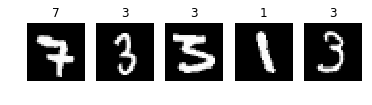

In [7]:
tf.logging.set_verbosity(tf.logging.ERROR)
print_predict_image(5, x_test, classifier, 'tf')